In [2]:
"""
Script to train the SOM-VAE model as described in https://arxiv.org/abs/1806.02199
Copyright (c) 2018
Author: Vincent Fortuin
Institution: Biomedical Informatics group, ETH Zurich
License: MIT License

If you want to optimize the hyperparameters using labwatch, you have to install labwatch and SMAC
and comment in the commented out lines.
"""

import os
import uuid
import shutil
from glob import glob
from datetime import date

import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import pandas as pd
from sklearn.metrics import mean_squared_error
from tqdm import tqdm, trange
import sacred
from sacred.stflow import LogFileWriter

# from labwatch.assistant import LabAssistant
# from labwatch.optimizers.random_search import RandomSearch
# from labwatch.optimizers.smac_wrapper import SMAC
# from labwatch.optimizers.bayesian_optimization import BayesianOptimization
# from labwatch import hyperparameters as hyper

from somvae_model import SOMVAE
from utils import *

ex = sacred.Experiment("hyperopt",interactive=True)
# ex = sacred.Experiment('jupyter_ex', interactive=True)
ex.observers.append(sacred.observers.FileStorageObserver.create("../sacred_runs"))
ex.captured_out_filter = sacred.utils.apply_backspaces_and_linefeeds

# ex.observers.append(sacred.observers.MongoObserver.create(db_name="somvae_hyperopt"))

# assistant = LabAssistant(ex, "somvae_hyperopt", optimizer=SMAC, url="localhost:{}".format(db_port))


@ex.config
def ex_config():
    """Sacred configuration for the experiment.
    
    Params:
        num_epochs (int): Number of training epochs.
        patience (int): Patience for the early stopping.
        batch_size (int): Batch size for the training.
        latent_dim (int): Dimensionality of the SOM-VAE's latent space.
        som_dim (list): Dimensionality of the self-organizing map.
        learning_rate (float): Learning rate for the optimization.
        alpha (float): Weight for the commitment loss.
        beta (float): Weight for the SOM loss.
        gamma (float): Weight for the transition probability loss.
        tau (float): Weight for the smoothness loss.
        decay_factor (float): Factor for the learning rate decay.
        name (string): Name of the experiment.
        ex_name (string): Unique name of this particular run.
        logdir (path): Directory for the experiment logs.
        modelpath (path): Path for the model checkpoints.
        interactive (bool): Indicator if there should be an interactive progress bar for the training.
        data_set (string): Data set for the training.
        save_model (bool): Indicator if the model checkpoints should be kept after training and evaluation.
        time_series (bool): Indicator if the model should be trained on linearly interpolated
            MNIST time series.
        mnist (bool): Indicator if the model is trained on MNIST-like data.
    """
    num_epochs = 20
    patience = 100
    batch_size = 32
    latent_dim = 64
    som_dim = [8,8]
    learning_rate = 0.0005
    alpha = 1.0
    beta = 0.9
    gamma = 1.8
    tau = 1.4
    decay_factor = 0.9
    name = ex.get_experiment_info()["name"]
    ex_name = "{}_{}_{}-{}_{}_{}".format(name, latent_dim, som_dim[0], som_dim[1], str(date.today()), uuid.uuid4().hex[:5])
    logdir = "../logs/{}".format(ex_name)
    modelpath = "../models/{}/{}.ckpt".format(ex_name, ex_name)
    interactive = True
    data_set = "MNIST_data"
    save_model = False
    time_series = True
    mnist = True


# @assistant.search_space
# def search_space():
#     num_epochs = 20
#     patience = 20
#     batch_size = 32
#     latent_dim = hyper.UniformInt(lower=64, upper=256, log_scale=True)
#     som_dim = [8,8]
#     learning_rate = hyper.UniformFloat(lower=0.0001, upper=0.01, log_scale=True)
#     alpha = hyper.UniformFloat(lower=0., upper=2.)
#     beta = hyper.UniformFloat(lower=0., upper=2.)
#     gamma = hyper.UniformFloat(lower=0., upper=2.)
#     tau = hyper.UniformFloat(lower=0., upper=2.)
#     decay_factor = hyper.UniformFloat(lower=0.8, upper=1.)
#     interactive = False

mnist = input_data.read_data_sets(f"../data/{ex_config()['data_set']}")

data_train = np.reshape(mnist.train.images, [-1,28,28,1])
labels_train = mnist.train.labels
data_val = data_train[45000:]
labels_val = labels_train[45000:]
data_train = data_train[:45000]
labels_train = data_train[:45000]


@ex.capture
def get_data_generator(time_series):
    """Creates a data generator for the training.
    
    Args:
        time_series (bool): Indicates whether or not we want interpolated MNIST time series or just
            normal MNIST batches.
    
    Returns:
        generator: Data generator for the batches."""

    def batch_generator(mode="train", batch_size=100):
        """Generator for the data batches.
        
        Args:
            mode (str): Mode in ['train', 'val'] that decides which data set the generator
                samples from (default: 'train').
            batch_size (int): The size of the batches (default: 100).
            
        Yields:
            np.array: Data batch.
        """
        assert mode in ["train", "val"], "The mode should be in {train, val}."
        if mode=="train":
            images = data_train.copy()
            labels = labels_train.copy()
        elif mode=="val":
            images = data_val.copy()
            labels = labels_val.copy()
        
        while True:
            indices = np.random.permutation(np.arange(len(images)))
            images = images[indices]
            labels = labels[indices]

            if time_series:
                for i, image in enumerate(images):
                    start_image = image
                    end_image = images[np.random.choice(np.where(labels == (labels[i] + 1) % 10)[0])]
                    interpolation = interpolate_arrays(start_image, end_image, batch_size)
                    yield interpolation + np.random.normal(scale=0.01, size=interpolation.shape)
            else:
                for i in range(len(images)//batch_size):
                    yield images[i*batch_size:(i+1)*batch_size]

    return batch_generator


@ex.capture
def train_model(model, x, lr_val, num_epochs, patience, batch_size, logdir,
        modelpath, learning_rate, interactive, generator):
    """Trains the SOM-VAE model.
    
    Args:
        model (SOM-VAE): SOM-VAE model to train.
        x (tf.Tensor): Input tensor or placeholder.
        lr_val (tf.Tensor): Placeholder for the learning rate value.
        num_epochs (int): Number of epochs to train.
        patience (int): Patience parameter for the early stopping.
        batch_size (int): Batch size for the training generator.
        logdir (path): Directory for saving the logs.
        modelpath (path): Path for saving the model checkpoints.
        learning_rate (float): Learning rate for the optimization.
        interactive (bool): Indicator if we want to have an interactive
            progress bar for training.
        generator (generator): Generator for the data batches.
    """
    train_gen = generator("train", batch_size)
    val_gen = generator("val", batch_size)

    num_batches = len(data_train)//batch_size

    saver = tf.train.Saver(keep_checkpoint_every_n_hours=2.)
    summaries = tf.summary.merge_all()

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        patience_count = 0
        test_losses = []
        with LogFileWriter(ex):
            train_writer = tf.summary.FileWriter(logdir+"/train", sess.graph)
            test_writer = tf.summary.FileWriter(logdir+"/test", sess.graph)
        print("Training...")
        train_step_SOMVAE, train_step_prob = model.optimize
        try:
            if interactive:
                pbar = tqdm(total=num_epochs*(num_batches)) 
            for epoch in range(num_epochs):
                batch_val = next(val_gen)
                test_loss, summary = sess.run([model.loss, summaries], feed_dict={x: batch_val})
                test_losses.append(test_loss)
                test_writer.add_summary(summary, tf.train.global_step(sess, model.global_step))
                if test_losses[-1] == min(test_losses):
                    saver.save(sess, modelpath, global_step=epoch)
                    patience_count = 0
                else:
                    patience_count += 1
                if patience_count >= patience:
                    break
                for i in range(num_batches):
                    batch_data = next(train_gen)
                    if i%100 == 0:
                        train_loss, summary = sess.run([model.loss, summaries], feed_dict={x: batch_data})
                        train_writer.add_summary(summary, tf.train.global_step(sess, model.global_step))
                    train_step_SOMVAE.run(feed_dict={x: batch_data, lr_val:learning_rate})
                    train_step_prob.run(feed_dict={x: batch_data, lr_val:learning_rate*100})
                    if interactive:
                        pbar.set_postfix(epoch=epoch, train_loss=train_loss, test_loss=test_loss, refresh=False)
                        pbar.update(1)

        except KeyboardInterrupt:
            pass
        finally:
            saver.save(sess, modelpath)
            if interactive:
                pbar.close()



@ex.capture
def evaluate_model(model, x, modelpath, batch_size):
    """Evaluates the performance of the trained model in terms of normalized
    mutual information, purity and mean squared error.
    
    Args:
        model (SOM-VAE): Trained SOM-VAE model to evaluate.
        x (tf.Tensor): Input tensor or placeholder.
        modelpath (path): Path from which to restore the model.
        batch_size (int): Batch size for the evaluation.
        
    Returns:
        dict: Dictionary of evaluation results (NMI, Purity, MSE).
    """
    saver = tf.train.Saver(keep_checkpoint_every_n_hours=2.)

    num_batches = len(data_val)//batch_size

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        saver.restore(sess, modelpath)

        test_k_all = []
        test_rec_all = []
        test_mse_all = []
        print("Evaluation...")
        for i in range(num_batches):
            batch_data = data_val[i*batch_size:(i+1)*batch_size]
            test_k_all.extend(sess.run(model.k, feed_dict={x: batch_data}))
            test_rec = sess.run(model.reconstruction_q, feed_dict={x: batch_data})
            test_rec_all.extend(test_rec)
            test_mse_all.append(mean_squared_error(test_rec.flatten(), batch_data.flatten()))

        test_nmi = compute_NMI(test_k_all, labels_val[:len(test_k_all)])
        test_purity = compute_purity(test_k_all, labels_val[:len(test_k_all)])
        test_mse = np.mean(test_mse_all)

    results = {}
    results["NMI"] = test_nmi
    results["Purity"] = test_purity
    results["MSE"] = test_mse
#    results["optimization_target"] = 1 - test_nmi

    return results
 

@ex.main
def main(latent_dim, som_dim, learning_rate, decay_factor, alpha, beta, gamma, tau, modelpath, save_model, mnist):
    """Main method to build a model, train it and evaluate it.
    
    Args:
        latent_dim (int): Dimensionality of the SOM-VAE's latent space.
        som_dim (list): Dimensionality of the SOM.
        learning_rate (float): Learning rate for the training.
        decay_factor (float): Factor for the learning rate decay.
        alpha (float): Weight for the commitment loss.
        beta (float): Weight for the SOM loss.
        gamma (float): Weight for the transition probability loss.
        tau (float): Weight for the smoothness loss.
        modelpath (path): Path for the model checkpoints.
        save_model (bool): Indicates if the model should be saved after training and evaluation.
        
    Returns:
        dict: Results of the evaluation (NMI, Purity, MSE).
    """
    # Dimensions for MNIST-like data
    input_length = 28
    input_channels = 28
    x = tf.placeholder(tf.float32, shape=[None, 28, 28, 1])

    data_generator = get_data_generator()

    lr_val = tf.placeholder_with_default(learning_rate, [])

    model = SOMVAE(inputs=x, latent_dim=latent_dim, som_dim=som_dim, learning_rate=lr_val, decay_factor=decay_factor,
            input_length=input_length, input_channels=input_channels, alpha=alpha, beta=beta, gamma=gamma,
            tau=tau, mnist=mnist)

    train_model(model, x, lr_val, generator=data_generator)

    result = evaluate_model(model, x)

    if not save_model:
        shutil.rmtree(os.path.dirname(modelpath))

    return result



Instructions for updating:
Use the retry module or similar alternatives.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../data/MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../data/MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
num_epochs = 20
patience = 100
batch_size = 32
latent_dim = 64
som_dim = [8,8]
learning_rate = 0.0005
alpha = 1.0
beta = 0.9
gamma = 1.8
tau = 1.4
decay_factor = 0.9
interactive = True
data_set = "MNIST_data"
save_model = False
time_series = True
mnist = True
input_length = 28
input_channels = 28
x = tf.placeholder(tf.float32, shape=[None, 28, 28, 1])
modelpath = "../models/hyperopt_64_8-8_2019-03-14_28585/hyperopt_64_8-8_2019-03-14_28585.ckpt"
batch_size = 32
num_batches = len(data_val)//batch_size
lr_val = tf.placeholder_with_default(learning_rate, [])

model = SOMVAE(inputs=x, latent_dim=latent_dim, som_dim=som_dim, learning_rate=lr_val, decay_factor=decay_factor,
        input_length=input_length, input_channels=input_channels, alpha=alpha, beta=beta, gamma=gamma,
        tau=tau, mnist=mnist)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    saver.restore(sess, modelpath)

    test_k_all = []
    test_rec_all = []
    test_mse_all = []
    print("Evaluation...")
    for i in range(num_batches):
        batch_data = data_val[i*batch_size:(i+1)*batch_size]
        test_k_all.extend(sess.run(model.k, feed_dict={x: batch_data}))
        test_rec = sess.run(model.reconstruction_q, feed_dict={x: batch_data})
        test_rec_all.extend(test_rec)
        test_mse_all.append(mean_squared_error(test_rec.flatten(), batch_data.flatten()))

    test_nmi = compute_NMI(test_k_all, labels_val[:len(test_k_all)])
    test_purity = compute_purity(test_k_all, labels_val[:len(test_k_all)])
    test_mse = np.mean(test_mse_all)

results = {}
results["NMI"] = test_nmi
results["Purity"] = test_purity
results["MSE"] = test_mse

INFO:tensorflow:Restoring parameters from ../models/hyperopt_64_8-8_2019-03-14_28585/hyperopt_64_8-8_2019-03-14_28585.ckpt
Evaluation...


In [4]:
results

{'MSE': 0.046796296, 'NMI': 0.5469336692124388, 'Purity': 0.6831931089743589}

In [5]:
batch_data[1].shape

(28, 28, 1)

In [6]:
model.reconstruction_q

<tf.Tensor 'reconstruction_q/decoder/Sigmoid:0' shape=(?, 28, 28, 1) dtype=float32>

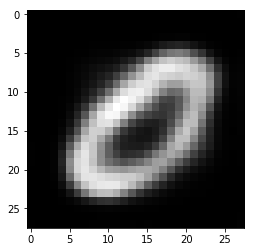

In [7]:
import matplotlib.pyplot as plt
plt.imshow(test_rec[0,:,:,0],"gray")
plt.show()

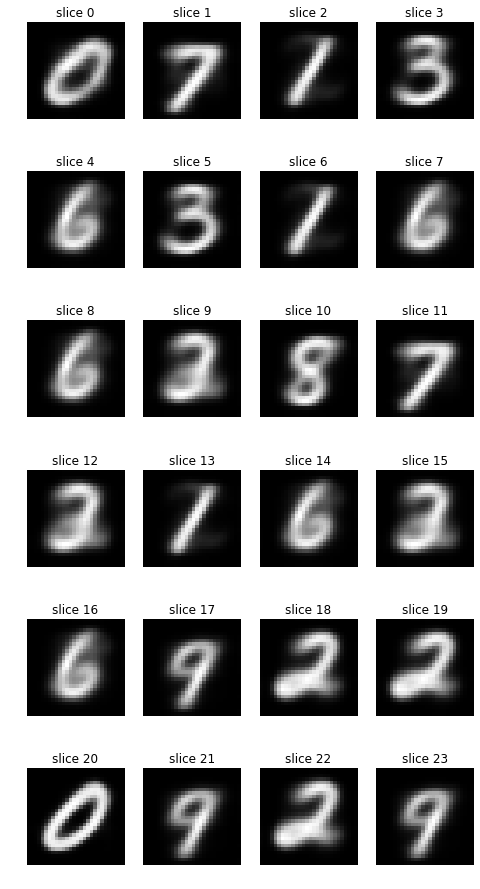

In [8]:
def sample_stack(stack, rows=6, cols=4):
    fig,ax = plt.subplots(rows,cols,figsize=[8,16])
    for i in range(rows*cols):
        ax[int(i/cols),int(i % cols)].set_title('slice %d' % i)
        ax[int(i/cols),int(i % cols)].imshow(stack[i,:,:,0],cmap='gray')
        ax[int(i/cols),int(i % cols)].axis('off')
    plt.show()

sample_stack(test_rec)

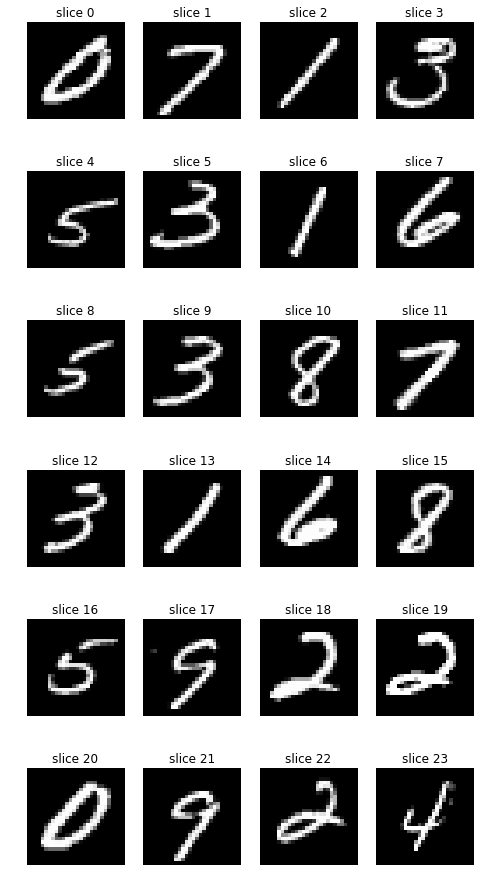

In [9]:
sample_stack(batch_data)

In [10]:
test_rec.flatten()

array([0.00118785, 0.00048938, 0.00029972, ..., 0.00080481, 0.00120247,
       0.00493401], dtype=float32)

In [12]:
mnist = input_data.read_data_sets(f"../data/{ex_config()['data_set']}")

data_train = np.reshape(mnist.train.images, [-1,28,28,1])
labels_train = mnist.train.labels
data_val = data_train[45000:]
labels_val = labels_train[45000:]
data_train = data_train[:45000]
labels_train = data_train[:45000]

Extracting ../data/MNIST_data/train-images-idx3-ubyte.gz
Extracting ../data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../data/MNIST_data/t10k-labels-idx1-ubyte.gz


In [16]:
mnist.train.images.shape

(55000, 784)

In [24]:
datatest = np.reshape(mnist.train.images, [55000,28,28,1])

In [29]:
datatest.shape

(55000, 28, 28, 1)

In [26]:
data_train.shape

(45000, 28, 28, 1)

In [27]:
labels_train.shape

(45000, 28, 28, 1)

In [28]:
data_val.shape

(10000, 28, 28, 1)